# Return Predictions From Trade Flow

## Introduction

### Can trade flow predict returns?

In this notebook, we assess trade flow as a means of generating profit opportunity in 3 crypto token markets. Specifically, we compute trade flow in $\tau$ second intervals and regress $T$-second forward returns on the trade flow to establish a measure of return predictability. Based on this measure, we perform a backtest to identify trade opportunities and assess how a trade may have performed.

Trade flow is a central idea in this analysis. It is a running tally of signed trade sizes where the sign is defined as 1 if the trade was seller-initiated and -1 if it was buyer-initiated. At any moment, we examine all reported trades within the last time period of length $\tau$. We define flow at time t as ${F_t^{(τ)} = V_{(t−τ,t)}^B − V_{(t−τ,t)}^S}$.

This can be normalized or transformed in many ways, with the goal of achieving more predictive forms. The essential idea behind flow as a quantitative metric is that, in circumstances when many sellers are willing to cross that market-making bid-offer spread to complete their transactions, there is likely to be new information driving their choices. We do not know exactly what it is, but we certainly want to adapt to it. 

## Data

Data has been pre-processed from level 3 exchange messages from the Coinbase WebSocket API into truncated level 2 data. The data used in this notebook contains trade tapes with marked trades for Bitcoin-USD, Ethereum-US, and Ethereum-Bitcoin for roughly a day and half at nanosecond frequency. 

Trades are recorded at both **received_utc_nanoseconds** and **timestamp_utc_nanoseconds**. Each timestamp represents the number of nanoseconds past midnight in UTC. The received time, also known as wall clock time, comes from the clock of the recording device, which was not synchronized to the exchange clock. The delay in recording skews the received time. The exchange timestamp, although accurate, may not be actionable due to price-time priority and because we do not see the data until later. Even though the received timestamp is an actionable time, in this analysis we consider the exchange timestamp as we are only concerned with opportunity identification. 

Helper functions can be found in utils.py.

### Exploratory Data Analysis

In [41]:
#imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from PIL import Image
from IPython.display import display
from utils import *
from importlib import reload 
import utils
reload(utils)
import warnings
warnings.filterwarnings('ignore')

In [5]:
pairs = ['BTC-USD', 'ETH-BTC', 'ETH-USD']
dfs = {pair: load_files(pair, 'trades') for pair in pairs}
btc_usd = dfs['BTC-USD']
eth_btc = dfs['ETH-BTC']
eth_usd = dfs['ETH-USD']

In [4]:
btc_usd

,PriceMillionths,SizeBillionths,Side
timestamp_utc_nanoseconds,,,
2023-01-24 00:47:47.874527,22970120000,87069600,-1
2023-01-24 00:47:47.874527,22970150000,25797600,-1
2023-01-24 00:47:47.878712,22970120000,10,-1
2023-01-24 00:47:47.886114,22969160000,217683140,-1
2023-01-24 00:47:48.676444,22969840000,10000000,1
...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1
2023-01-25 15:50:01.543105,22571970000,335000000,-1
2023-01-25 15:50:01.601688,22570920000,50000000,-1


Let us inspect trade volumes in minute intervals. 

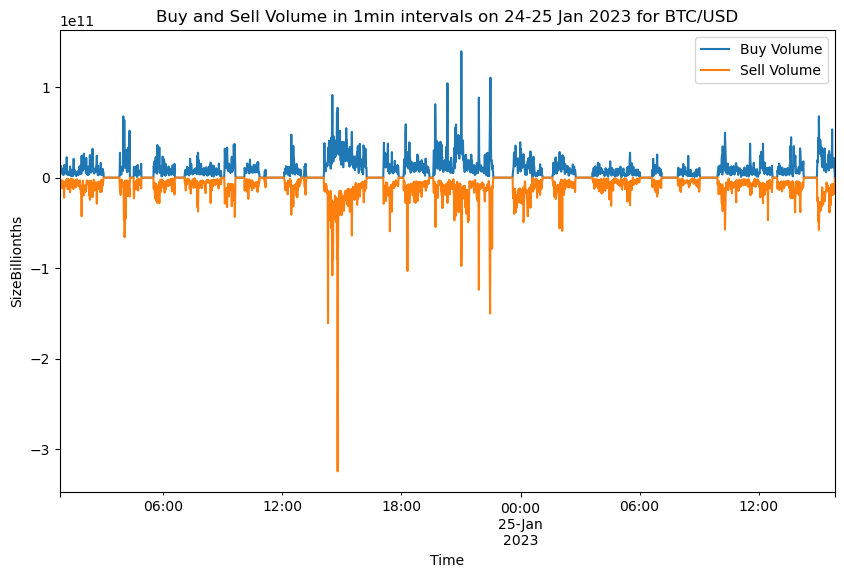

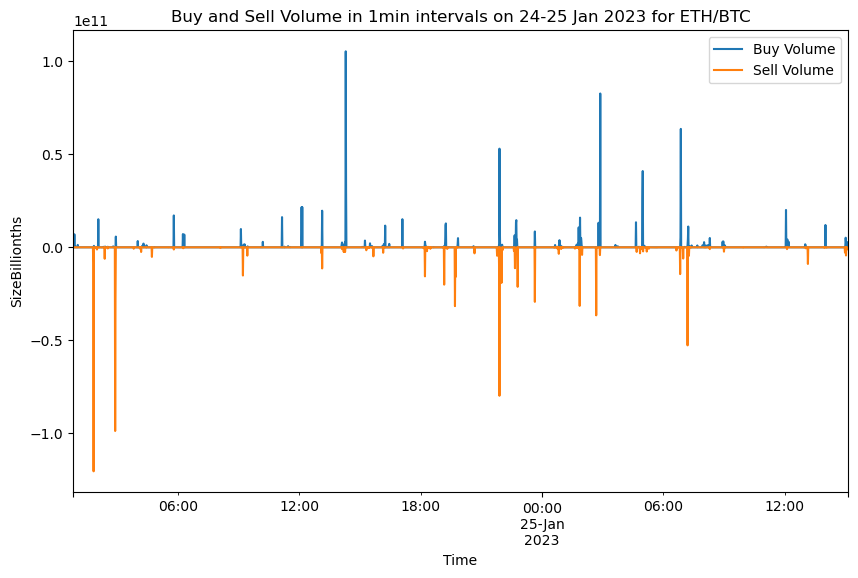

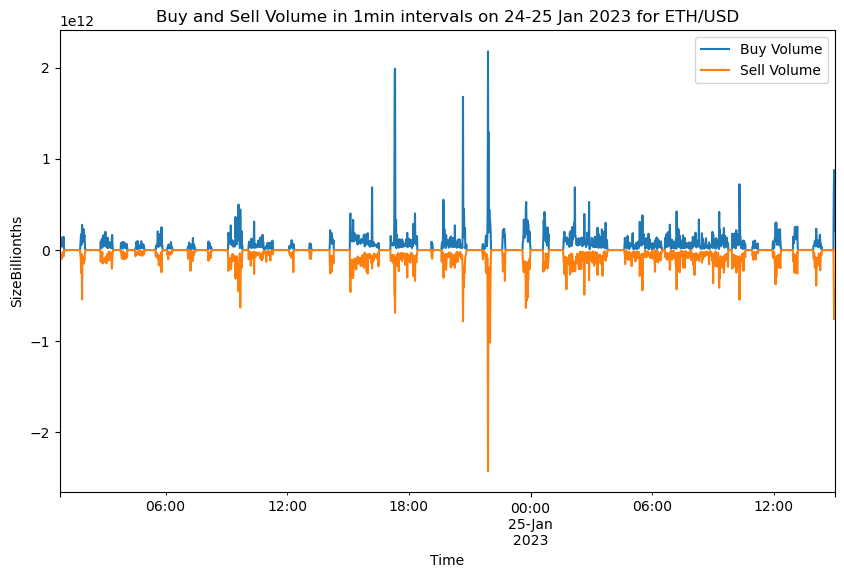

In [6]:
plot_buy_sell_volumes(btc_usd, 'BTC/USD')
plot_buy_sell_volumes(eth_btc, 'ETH/BTC')
plot_buy_sell_volumes(eth_usd, 'ETH/USD')

We observe that that there are several spikes in the volumes, and equally-sized buys occur almost right after sells in large trades. It is more evident in the zoomed in plots below, where most of the volume sold is bought within 10-15 minutes of the trade, except in the case of ETH-BTC, where ETH is more often exchanged for BTC. There is far less trading in the ETH-BTC market as well, so we expect to run into the most issues with return predictability for this market. 

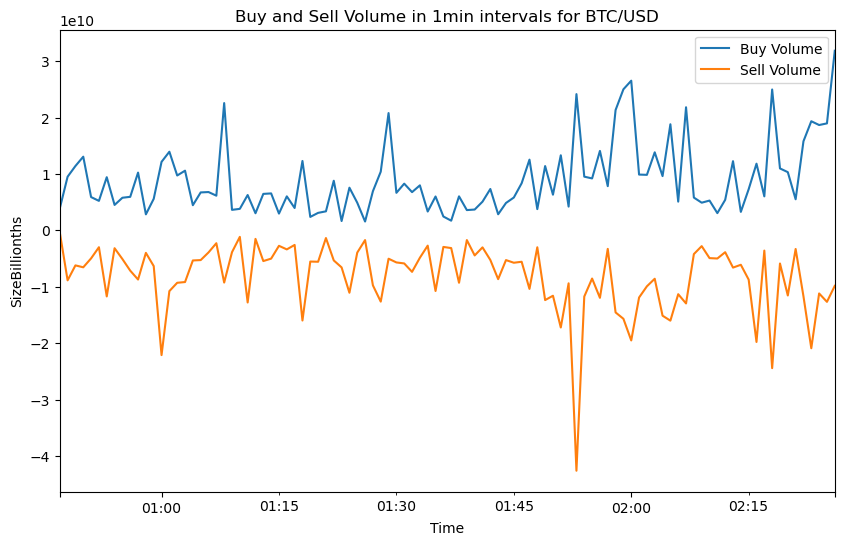

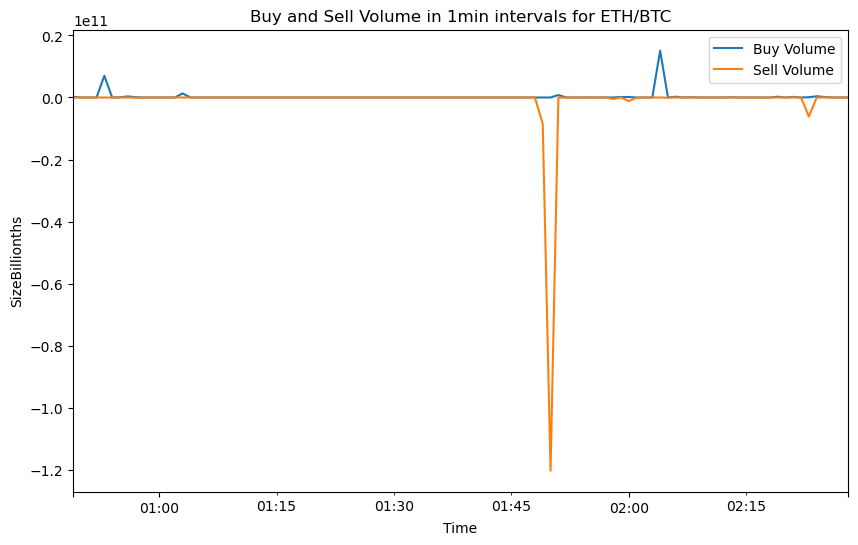

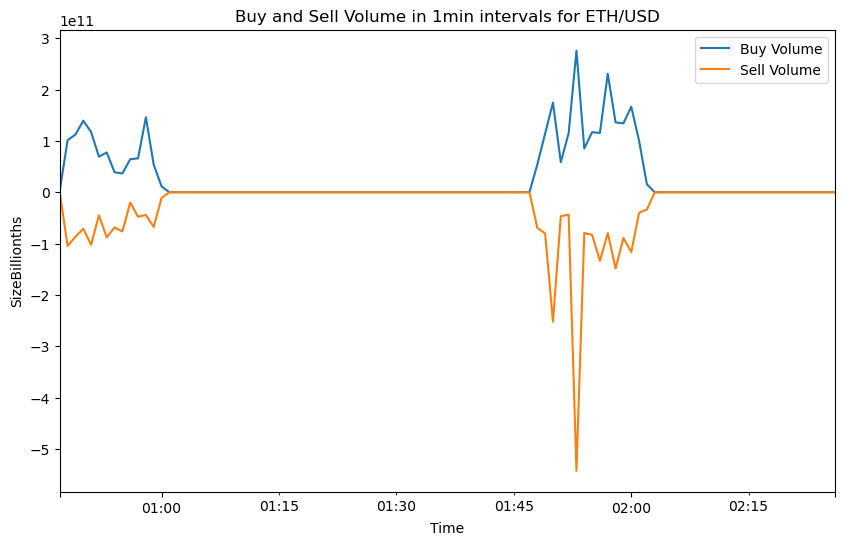

In [8]:
plot_buy_sell_volumes(btc_usd, 'BTC/USD', subset=True)
plot_buy_sell_volumes(eth_btc, 'ETH/BTC', subset=True)
plot_buy_sell_volumes(eth_usd, 'ETH/USD', subset=True)

Average Prices and Volumes

<Figure size 1000x600 with 0 Axes>

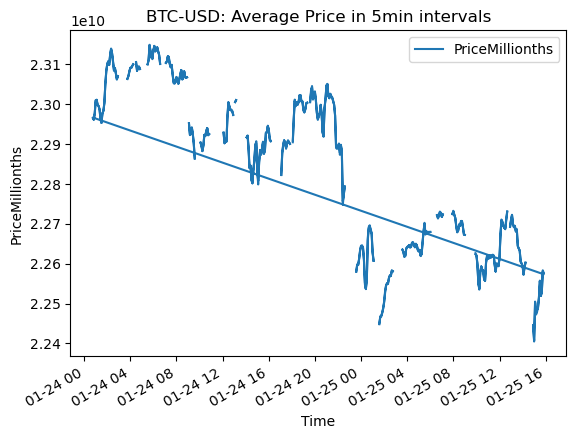

<Figure size 1000x600 with 0 Axes>

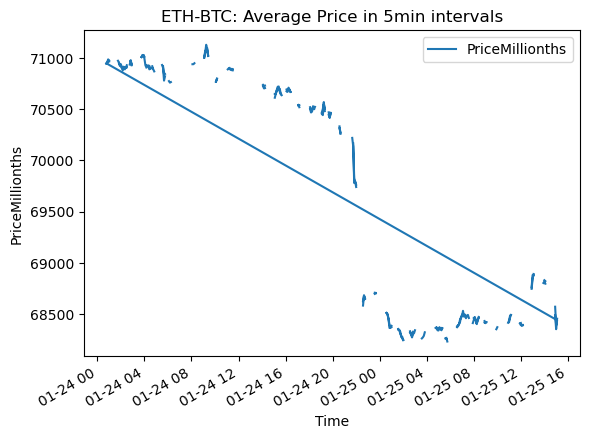

<Figure size 1000x600 with 0 Axes>

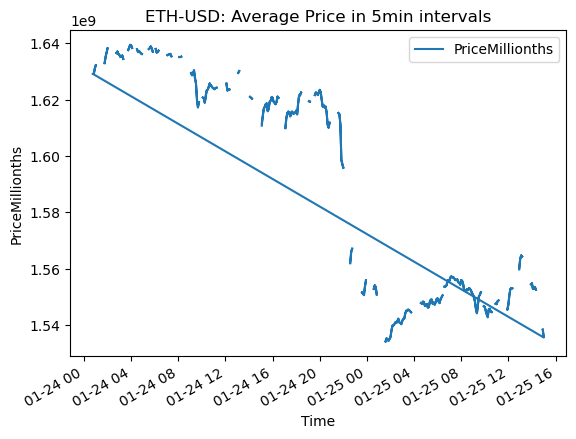

In [10]:
plot_average_price(btc_usd, 'BTC-USD')
plot_average_price(eth_btc, 'ETH-BTC')
plot_average_price(eth_usd, 'ETH-USD')


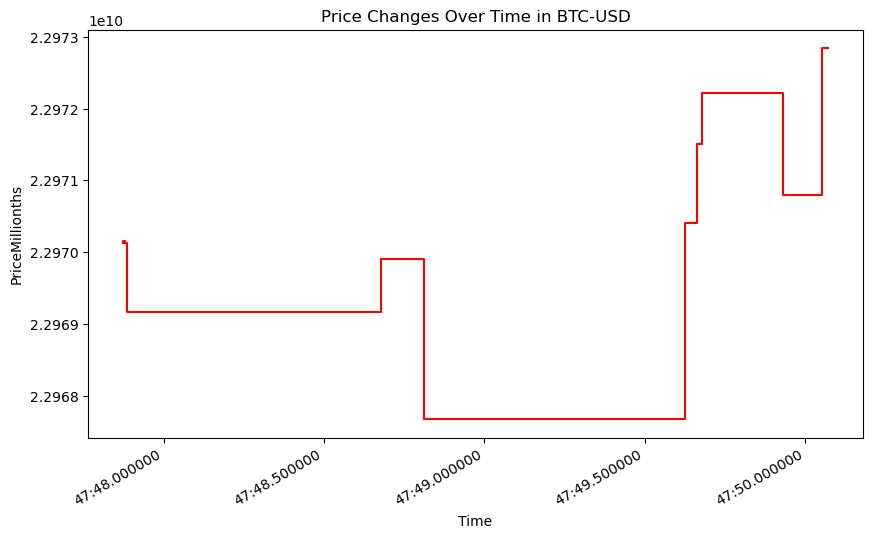

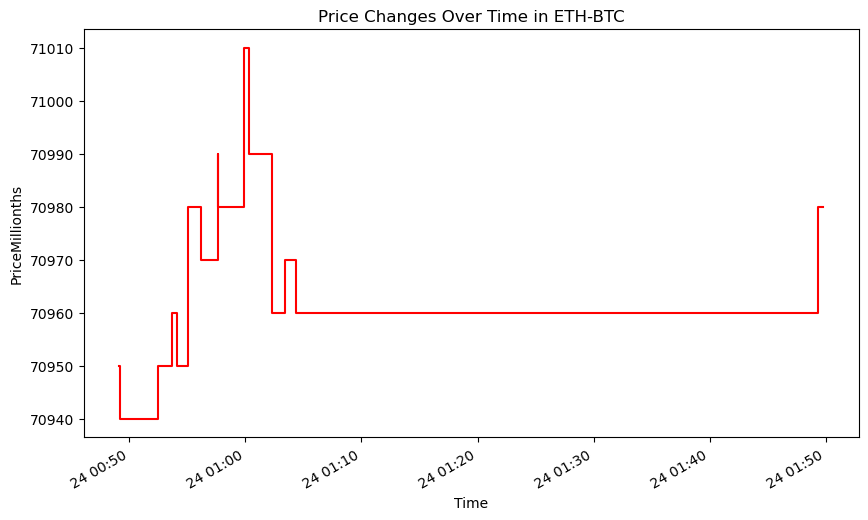

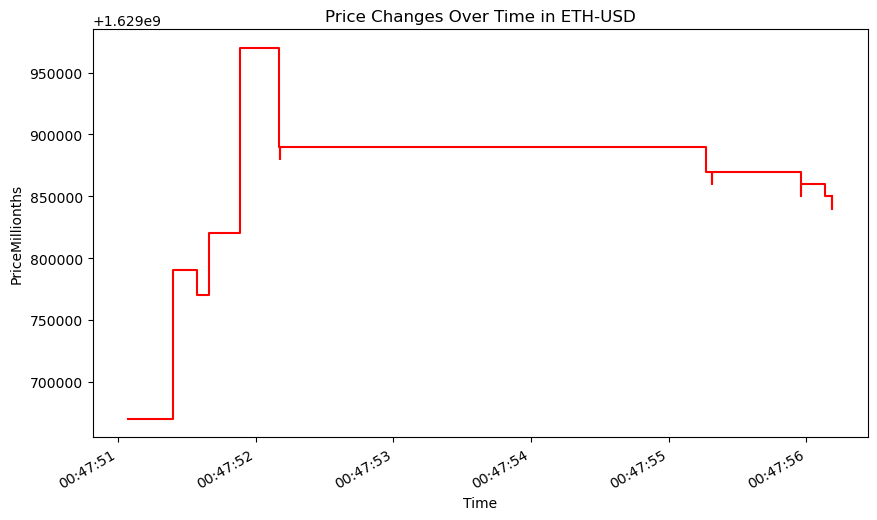

In [235]:
plot_price_changes(btc_usd, 'BTC-USD')
plot_price_changes(eth_btc, 'ETH-BTC')
plot_price_changes(eth_usd, 'ETH-USD')


<Figure size 1000x600 with 0 Axes>

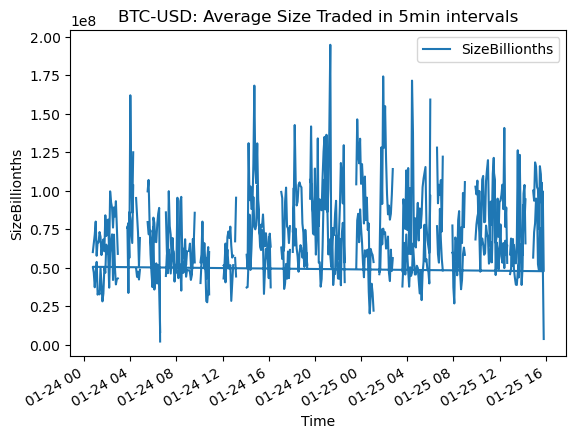

<Figure size 1000x600 with 0 Axes>

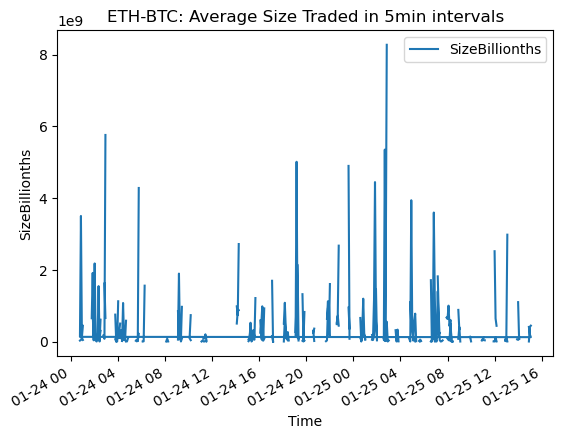

<Figure size 1000x600 with 0 Axes>

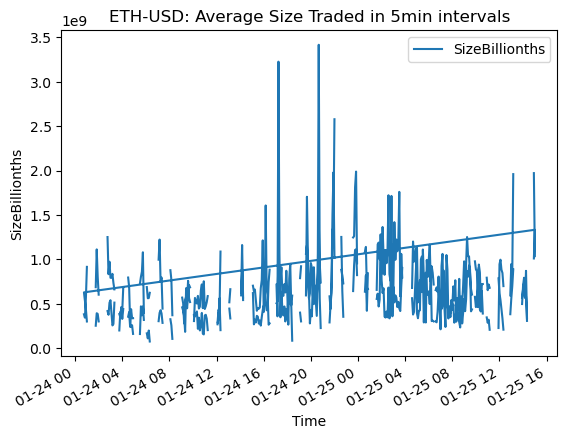

In [237]:
plot_average_size(btc_usd, 'BTC-USD')
plot_average_size(eth_btc, 'ETH-BTC')
plot_average_size(eth_usd, 'ETH-USD')

Prices display negative drift in 5-minute intervals, and thus may skew the results of trading. In this nanosecond-frequency analysis, we assume drift to be 0 within a nanosecond interval.

There seem to be several gaps in the trading history, so we observe the Epps effect - a common issue with tick level data where there are long periods of boredom interrupted by short intervals of terror. That is, data updates come at certain times (often bunched) so at a sufficiently small timescale correlations appear to drop to zero. The lack of trading activity adversely affects return predictability as the regressor matrix is full of 0s, and is hence linearly dependent. 


In [418]:
btc_usd.shape

(560107, 3)

In [417]:
btc_usd.index.duplicated().sum() # around a third of timestamps have multiple trades

190623

### Trade Flow and Forward Returns

We compute the $\tau$ interval trade flow $F_i^{(\tau)}$ just prior to each trade data point. The $\tau$ interval trade flow is defined as ${F_t^{(τ)} = V_{[t−τ,t)}^B − V_{[t−τ,t)}^S}$. We exclude the last point as we do not know the flow at time t. Around one third of the timestamps have multiple trades. Such trades are usually initiated by a large market player who wants to make a big trade but cannot execute the whole quantity at one price, so they split it out over multiple transactions. Such trades also indicate that the player may not be finished executing, so there is a chance the flow will continue, which will help us predict returns if we correctly anticipate future flow. This makes trade flow an actionable predictor, since if we observe large flow within a certain time interval, it is an indication to cross the spread to make a trade.

When using tick data, its timestamps $t_i$ are irregular.  We want values from our time series as of a _different_ set of timestamps $\tau_i$, and we want the computation to be vectorized for speed. Hence we create a new series of timestamps at regular $\tau$ intervals and forward fill.

We also compute the $T$-second forward returns as $p_{t+T} / p_t - 1$. The forward index we need may not always exist so we reindex the data to the nearest point. We regress the forward returns against trade flow without an intercept. An intercept represents a drift from the price, and due to the Bayesian prior, we expect the intercept to be 0 in nanosecond-intervals, unlike in minutely intervals. 

We then split the data into training and test sets, with the training set containing the first 40% of the data, and compute the predicted returns from the test set as $\hat{r_i} = \beta F_i^{(\tau)}$. Trade flows are in billionths and returns are in the order 10e-4 for most returns. Due to the difference in scales, we also perform a scaled regression.

Note: Some of the forward returns in the training set contain price data from the test set, and some of the trade flow sizes in the test set contain trade data from the training set. As such there is some lookahead bias and lookback bias in the analysis, respectively. The time windows are small enough relative to the dataset size that correcting for this will not have a material effect, whilst reducing the processing time.

We check multiple values of both $\tau$ and $T$. We want the lookahead bias to be less than the lookback bias, so we set $\tau$ to be larger than $T$. Both of them must be in the same order of magnitude.​ Values too large will aggregate trade flow to the point we lose return predictability for trading, whereas values too small will result in too many points with 0 trade flow, which will affect the regression.


### Trading

Based on the regression $\hat{r_i} = \beta F_i^{(\tau)}$, we define thresholds $j$, and trade whenever $j < |\hat{r_i}|$. We check a range of values for $j$ between the 15 and 65 percentiles of predicted returns. We choose $j$ as such because we want to participate in trades relatively frequently, but not too often, as it would be unrealistic given the window sizes $\tau$ and $T$.

We allow multiple positions to be open without worrying about their interaction. This allows us to vectorize everything for faster performance, and is particularly necessary for nanosecond-frequency data on the local machine.

In [7]:
# reference unit is seconds
tau_T_set = {(2, 1), (5, 2), (10, 5), (60, 30), (180, 120)}

# create a set of pairs (t, T) where t and T are in the same order of magnitude and tau > T
#tau_T_set = {(t_val, T_val) for t_val in tau for T_val in T if (math.floor(math.log10(t_val)) == math.floor(math.log10(T_val)) and t_val > T_val)}


In [42]:
datasets = ['train', 'test', 'validation', 'TradeResults', 'ParticipationRates']
results_dict = {pair: {tau_T: {dataset: None for dataset in datasets} for tau_T in tau_T_set} for pair in pairs}
n_folds = 4
scaler = StandardScaler()

for pair, df in dfs.items():
    for (tau, T) in tau_T_set:

        trade_flow = compute_trade_flow(df, tau)
        forward_returns = compute_forward_returns(df, tau, T)
        merged_df = pd.concat([trade_flow, forward_returns], axis=1)
        train_set = split_data(pair, merged_df)[0]
        test_set = split_data(pair, merged_df)[1]
        regBeta = regressionBeta(train_set['TradeFlow'], train_set['ForwardReturns'])
        scaledRegBeta = scaledregressionBeta(train_set['TradeFlow'], train_set['ForwardReturns'])
        predicted_returns = regBeta * test_set['TradeFlow']
        scaled_pred_returns = scaledRegBeta * test_set['TradeFlow']
        cv_betas, cv_rmse, cv_pred = cv_beta(trade_flow['TradeFlow'], forward_returns, n_folds, pair, tau, T, regBeta)

        trade_results, participation_rates = trade_signals(test_set, regBeta, predicted_returns, pair, tau, T, 
                                                           price_col_name='PriceMillionths', init_cash=1000000, 
                                                           trading_cost=0.0)
        trade_results_tc, participation_rates_tc = trade_signals(test_set, regBeta, predicted_returns, pair, tau, T, 
                                                                 price_col_name='PriceMillionths', init_cash=1000000, 
                                                                 trading_cost=0.001)
        trade_results_scaled, participation_rates_scaled = trade_signals(test_set, scaledRegBeta, predicted_returns, pair, tau, T, 
                                                           price_col_name='PriceMillionths', init_cash=1000000, 
                                                           trading_cost=0.0)
        trade_results_tc_scaled, participation_rates_tc_scaled = trade_signals(test_set, scaledRegBeta, predicted_returns, pair, tau, T, 
                                                                 price_col_name='PriceMillionths', init_cash=1000000, 
                                                                 trading_cost=0.001)
        
        results_dict[pair][(tau, T)]['train'] = {'TrainSet': train_set, 'RegressionBeta': regBeta, 'ScaledRegBeta': scaledRegBeta}
        results_dict[pair][(tau, T)]['test'] = {'TestSet': test_set, 'PredictedReturns': predicted_returns, 'ScaledPredictedReturns': scaled_pred_returns}
        results_dict[pair][(tau, T)]['validation'] = {'Betas': cv_betas, 'RMSE': cv_rmse, 'PredictedReturns': cv_pred}
        results_dict[pair][(tau, T)]['TradeResults'] = {'SimpleReg': {'NoTradingCost': trade_results, 'TradingCost': trade_results_tc}}
        results_dict[pair][(tau, T)]['TradeResults'] = {'ScaledReg': {'NoTradingCost': trade_results_scaled, 'TradingCost': trade_results_tc_scaled}}
        results_dict[pair][(tau, T)]['ParticipationRates'] = {'ScaledReg': {'NoTradingCost': participation_rates, 'TradingCost': participation_rates_tc}}
        results_dict[pair][(tau, T)]['ParticipationRates'] = {'ScaledReg': {'NoTradingCost': participation_rates_scaled, 'TradingCost': participation_rates_tc_scaled}}


print('positions | done.')

positions | done.


## Analysis

We illustrate the analysis of signals for a trade flow window of $\tau = 2$ and forward returns window of $T = 1$.

### BTC-USD

In [43]:
tau_T_val = (2, 1)
pair = 'BTC-USD'
scaled_r_hat_2_1 = results_dict[pair][*tau_T_val]['test']['ScaledPredictedReturns']
scaled_reg_beta_2_1 = results_dict[pair][*tau_T_val]['train']['ScaledRegBeta']
scaled_reg_beta_2_1

-0.029096229706407545

In [26]:
train_set_2_1 = results_dict['BTC-USD'][*tau_T_val]['train']['TrainSet']
train_set_2_1

,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns
timestamp_utc_nanoseconds,,,,,,
2023-01-24 00:47:47.874527,22970120000,87069600,-1,-87069600,0.000000e+00,1.306045e-06
2023-01-24 00:47:47.874527,22970120000,87069600,-1,-87069600,0.000000e+00,1.306045e-06
2023-01-24 00:47:47.878712,22970120000,10,-1,-10,-1.741392e+08,-4.179343e-05
2023-01-24 00:47:47.886114,22969160000,217683140,-1,-217683140,-1.741392e+08,2.960491e-05
2023-01-24 00:47:48.676444,22969840000,10000000,1,10000000,-3.918224e+08,4.353535e-07
...,...,...,...,...,...,...
2023-01-24 15:38:42.941803,22883810000,99571700,-1,-99571700,-3.899207e+08,3.932912e-06
2023-01-24 15:38:42.941803,22883810000,99571700,-1,-99571700,-3.899207e+08,3.932912e-06
2023-01-24 15:38:42.943572,22883690000,442901030,-1,-442901030,-7.882075e+08,-1.442075e-05


In [44]:
reg_beta_2_1 = results_dict['BTC-USD'][*tau_T_val]['train']['RegressionBeta']
reg_beta_2_1

-2.9626431525482344e-16

The regression beta is negative, which means an increase in trade flow is associated with decreased returns. If there is a large negative trade flow, we would want to sell large amounts. Conversely, if beta was positive and there was a large trade flow, we would want to buy from aggressive sellers.

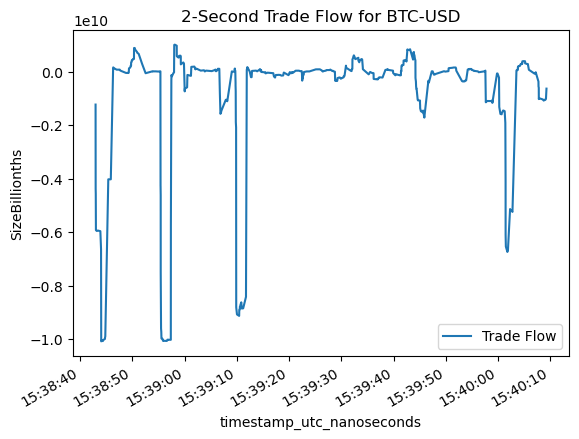

In [48]:
trade_flow = results_dict['BTC-USD'][*tau_T_val]['test']['TestSet']['TradeFlow']
trade_flow[0:1000].plot(label='Trade Flow')
plt.ylabel('SizeBillionths')
plt.title('2-Second Trade Flow for BTC-USD')
plt.legend()
plt.show()

There are indeed large sells in this subset. We want to sell positions when such trade flows occurs.

In [50]:
test_set_2_1 = results_dict['BTC-USD'][*tau_T_val]['test']['TestSet']
test_set_2_1


,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns
timestamp_utc_nanoseconds,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05
...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00


In [49]:
r_hat_2_1 = results_dict['BTC-USD'][*tau_T_val]['test']['PredictedReturns']
r_hat_2_1

timestamp_utc_nanoseconds
2023-01-24 15:38:42.959644    3.647335e-07
2023-01-24 15:38:42.959644    3.647335e-07
2023-01-24 15:38:42.959663    7.012047e-07
2023-01-24 15:38:42.959663    7.012047e-07
2023-01-24 15:38:42.964726    7.613640e-07
                                  ...     
2023-01-25 15:50:01.477570    1.118004e-07
2023-01-25 15:50:01.543105    1.117031e-07
2023-01-25 15:50:01.601688    2.109516e-07
2023-01-25 15:50:01.601719    2.257648e-07
2023-01-25 15:50:01.601767    2.354231e-07
Name: TradeFlow, Length: 378223, dtype: float64

count    3.782230e+05
mean     1.810056e-07
std      1.323695e-06
min     -8.747206e-06
25%     -5.522696e-08
50%      2.162404e-10
75%      1.472990e-07
max      6.817162e-05
Name: TradeFlow, dtype: float64


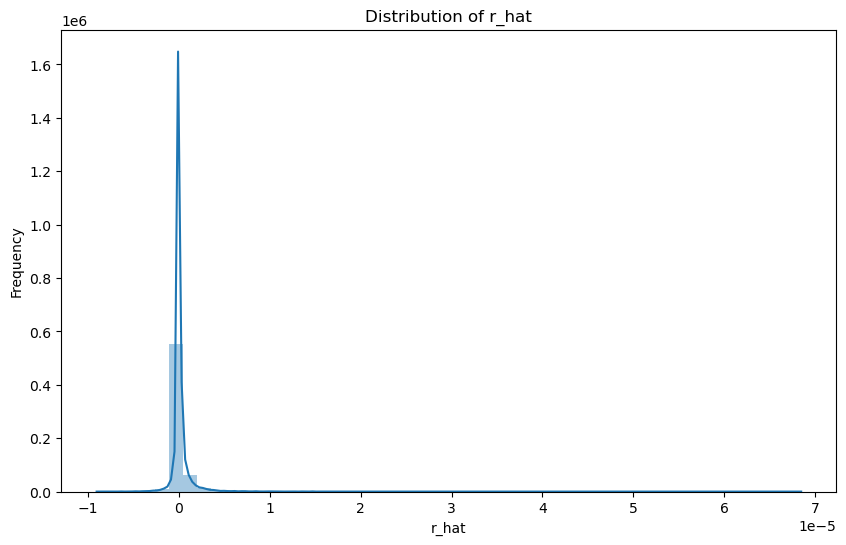

In [51]:
summary = r_hat_2_1.describe()
print(summary)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.distplot(r_hat_2_1, bins=50, kde=True)
plt.title('Distribution of r_hat')
plt.xlabel('r_hat')
plt.ylabel('Frequency')
plt.show()

We look at the strategy with a trading cost of 0.001 per each billionth token.

In [52]:
resd, partd = trade_signals(test_set_2_1, reg_beta_2_1, r_hat_2_1, 'BTC-USD', 2, 1, price_col_name='PriceMillionths', init_cash=1000000, trading_cost=0.001)


In [54]:
for j in resd.keys():
    display(resd[j]['df']) 

,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns,signal,position,trading_cost,position_value,cash,total_value,accum_quantity,PnL,PnL_cumulative
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,1000000,-6.497231e+18,-283928180,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,22884360000,-6.497231e+18,-567856360,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,45767710000,-2.323342e+18,-669386170,4.173889e+18,4.173889e+18
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,68651060000,-2.323342e+18,-770915980,0.000000e+00,4.173889e+18
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05,-1,-226606950,226606.95,-5.185728e+18,91535300000,-5.185728e+18,-997522930,-2.862386e+18,1.311503e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05,1,920730,920.73,2.078371e+16,-1057318565910000,1.972639e+16,-7073793632290,4.590767e+16,6.518014e+18
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05,-1,-335000000,335000.00,-7.561610e+18,-1057295993940000,-7.562667e+18,-7074128632290,-7.582394e+18,-1.064379e+18
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00,-1,-50000000,50000.00,-1.128546e+18,-1057273423020000,-1.129603e+18,-7074178632290,6.433064e+18,5.368685e+18


,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns,signal,position,trading_cost,position_value,cash,total_value,accum_quantity,PnL,PnL_cumulative
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,1000000,-6.497231e+18,-283928180,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,22884360000,-6.497231e+18,-567856360,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,45767710000,-2.323342e+18,-669386170,4.173889e+18,4.173889e+18
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,68651060000,-2.323342e+18,-770915980,0.000000e+00,4.173889e+18
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05,-1,-226606950,226606.95,-5.185728e+18,91535300000,-5.185728e+18,-997522930,-2.862386e+18,1.311503e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05,1,920730,920.73,2.078371e+16,-875840512170000,1.990787e+16,-6675166263050,4.590767e+16,6.518014e+18
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05,-1,-335000000,335000.00,-7.561610e+18,-875817940200000,-7.562486e+18,-6675501263050,-7.582394e+18,-1.064379e+18
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00,-1,-50000000,50000.00,-1.128546e+18,-875795369280000,-1.129422e+18,-6675551263050,6.433064e+18,5.368685e+18


,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns,signal,position,trading_cost,position_value,cash,total_value,accum_quantity,PnL,PnL_cumulative
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,1000000,-6.497231e+18,-283928180,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,22884360000,-6.497231e+18,-567856360,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,45767710000,-2.323342e+18,-669386170,4.173889e+18,4.173889e+18
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,68651060000,-2.323342e+18,-770915980,0.000000e+00,4.173889e+18
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05,-1,-226606950,226606.95,-5.185728e+18,91535300000,-5.185728e+18,-997522930,-2.862386e+18,1.311503e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05,1,920730,920.73,2.078371e+16,-742718939360000,2.004099e+16,-6161235280530,4.590767e+16,6.518014e+18
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05,-1,-335000000,335000.00,-7.561610e+18,-742696367390000,-7.562353e+18,-6161570280530,-7.582394e+18,-1.064379e+18
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00,-1,-50000000,50000.00,-1.128546e+18,-742673796470000,-1.129289e+18,-6161620280530,6.433064e+18,5.368685e+18


,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns,signal,position,trading_cost,position_value,cash,total_value,accum_quantity,PnL,PnL_cumulative
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,1000000,-6.497231e+18,-283928180,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,22884360000,-6.497231e+18,-567856360,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,45767710000,-2.323342e+18,-669386170,4.173889e+18,4.173889e+18
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,68651060000,-2.323342e+18,-770915980,0.000000e+00,4.173889e+18
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05,-1,-226606950,226606.95,-5.185728e+18,91535300000,-5.185728e+18,-997522930,-2.862386e+18,1.311503e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05,1,920730,920.73,2.078371e+16,-563550039850000,2.022016e+16,-5825925175550,4.590767e+16,6.518014e+18
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05,-1,-335000000,335000.00,-7.561610e+18,-563527467880000,-7.562173e+18,-5826260175550,-7.582394e+18,-1.064379e+18
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00,-1,-50000000,50000.00,-1.128546e+18,-563504896960000,-1.129110e+18,-5826310175550,6.433064e+18,5.368685e+18


,PriceMillionths,SizeBillionths,Side,CumSize,TradeFlow,ForwardReturns,signal,position,trading_cost,position_value,cash,total_value,accum_quantity,PnL,PnL_cumulative
timestamp_utc_nanoseconds,,,,,,,,,,,,,,,
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,1000000,-6.497231e+18,-283928180,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959644,22883360000,283928180,-1,-283928180,-1.231108e+09,8.739975e-07,-1,-283928180,283928.18,-6.497231e+18,22884360000,-6.497231e+18,-567856360,0.000000e+00,0.000000e+00
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,45767710000,-2.323342e+18,-669386170,4.173889e+18,4.173889e+18
2023-01-24 15:38:42.959663,22883350000,101529810,-1,-101529810,-2.366821e+09,4.369990e-07,-1,-101529810,101529.81,-2.323342e+18,68651060000,-2.323342e+18,-770915980,0.000000e+00,4.173889e+18
2023-01-24 15:38:42.964726,22884240000,226606950,-1,-226606950,-2.569881e+09,-3.801743e-05,-1,-226606950,226606.95,-5.185728e+18,91535300000,-5.185728e+18,-997522930,-2.862386e+18,1.311503e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 15:50:01.477570,22573080000,920730,1,920730,-3.773671e+08,-4.917362e-05,0,0,0.00,0.000000e+00,-412623045300000,-4.126230e+14,-5038216892650,0.000000e+00,6.497231e+18
2023-01-25 15:50:01.543105,22571970000,335000000,-1,-335000000,-3.770386e+08,-4.651787e-05,0,0,0.00,0.000000e+00,-412623045300000,-4.126230e+14,-5038216892650,0.000000e+00,6.497231e+18
2023-01-25 15:50:01.601688,22570920000,50000000,-1,-50000000,-7.120386e+08,0.000000e+00,-1,-50000000,50000.00,-1.128546e+18,-412600474380000,-1.128959e+18,-5038266892650,-1.128546e+18,5.368685e+18


In [55]:
for j in resd.keys():
    display(resd[j]['metrics']) 

{'sharpe_ratio': 8.517613697721093e-06,
 'max_drawdown': -1.8440341551682857e+19,
 'sortino_ratio': 7.4888964332345185e-06}

{'sharpe_ratio': 8.728446118142235e-06,
 'max_drawdown': -1.8440341551682861e+19,
 'sortino_ratio': 7.344531477307815e-06}

{'sharpe_ratio': 9.018716663627218e-06,
 'max_drawdown': -1.8440341551682892e+19,
 'sortino_ratio': 7.168026216046579e-06}

{'sharpe_ratio': 9.50125025465306e-06,
 'max_drawdown': -1.8440341551682925e+19,
 'sortino_ratio': 6.993309931770739e-06}

{'sharpe_ratio': 1.0242588863978563e-05,
 'max_drawdown': -1.8440341551682912e+19,
 'sortino_ratio': 6.85116373277467e-06}

The Sharpe and Sortino ratios over the period for each threshold are very small, which is to be expected as the ratios are not scaled for time. The max drawdown is also very negative, suggesting large losses. 

In [155]:
btcusd_trades_test_analysis = calcTradeStats(test_set_2_1, reg_beta_2_1, r_hat_2_1, j, 'PriceMillionths', 1000000, 0.0001)


positions | done.


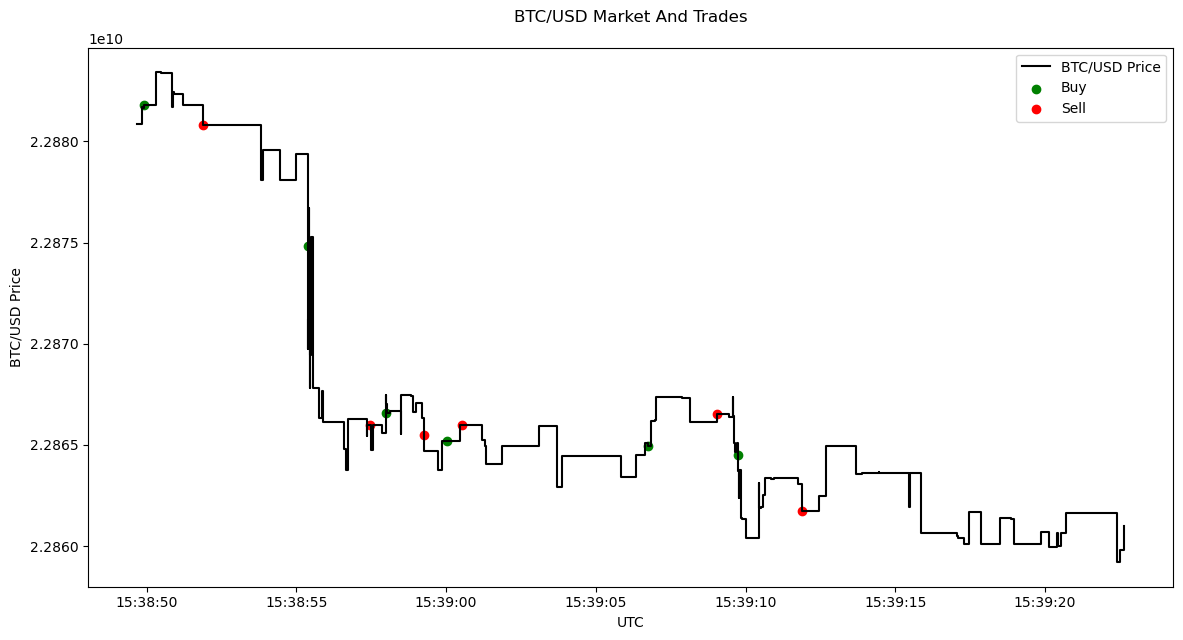

In [159]:
plt.figure(figsize=(14, 7))

subdf = btcusd_trades_test_analysis[100:500]

plt.step(subdf.index, 
         subdf['PriceMillionths'], where='post', label='BTC/USD Price', color='black')

buy_signals = subdf['signal'] > 0
sell_signals = subdf['signal'] < 0

plt.scatter(subdf[buy_signals].index, 
            subdf[buy_signals]['PriceMillionths'], color='green', label='Buy')
plt.scatter(subdf[sell_signals].index, 
            subdf[sell_signals]['PriceMillionths'], color='red', label='Sell')

plt.title('BTC/USD Market And Trades\n')
plt.xlabel('UTC')
plt.ylabel('BTC/USD Price')
plt.legend()

plt.show()

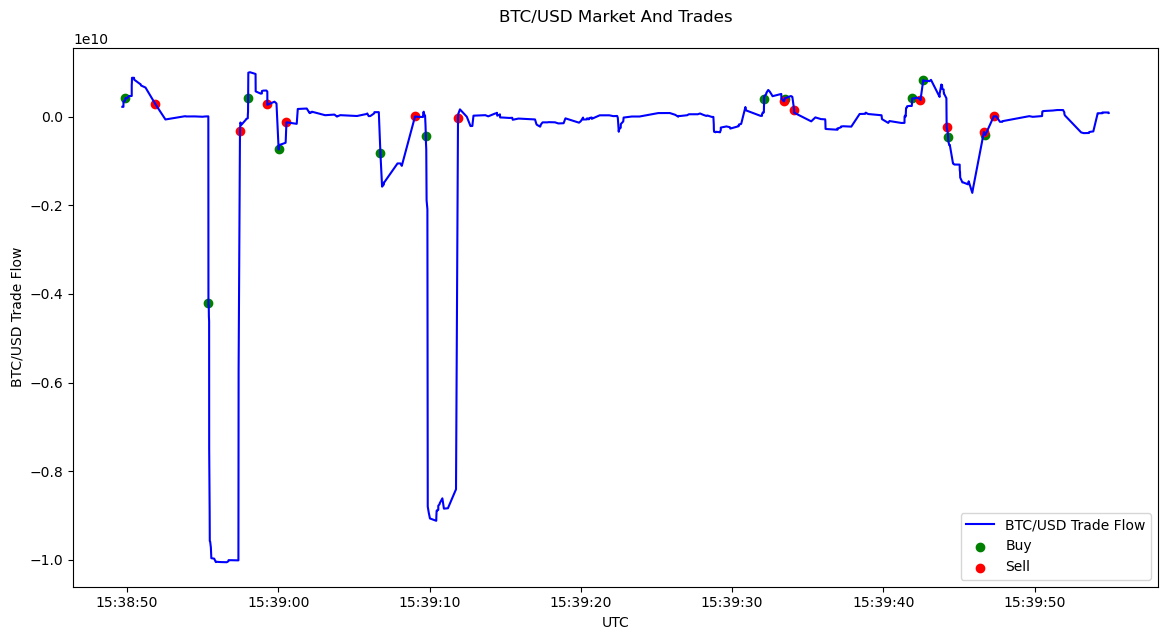

In [165]:
plt.figure(figsize=(14, 7))

subdf = btcusd_trades_test_analysis[100:800]
buy_signals = subdf['signal'] > 0
sell_signals = subdf['signal'] < 0

plt.plot(subdf.index, subdf['TradeFlow'], label='BTC/USD Trade Flow', color='blue')
plt.scatter(subdf[buy_signals].index, 
            subdf[buy_signals]['TradeFlow'], color='green', label='Buy')
plt.scatter(subdf[sell_signals].index, 
            subdf[sell_signals]['TradeFlow'], color='red', label='Sell')

plt.title('BTC/USD Market And Trades\n')
plt.xlabel('UTC')
plt.ylabel('BTC/USD Trade Flow')
plt.legend()

plt.show()

When flow has a stable sign over macroscopic periods of time, it is a manifestation of supply and demand imbalance, and so it usually corresponds to steady price movements over a given time period. In a price time series, this has the appearance of momentum but the fundamental underlying process is economic (rather than the mysticism of momentum). An increase in negative trade flow causes price to decline. The plot shows that we bought when prices had not dropped to the lowest level in that subperiod. This indicates that we underestimated the impact of absolute trade flow in that period. 

Threshold $j$

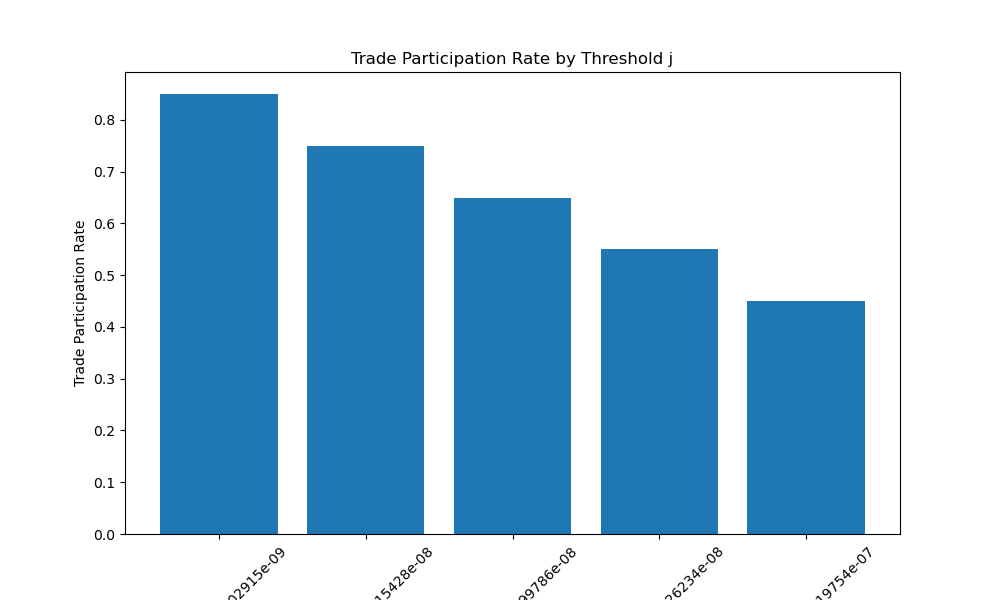

In [40]:
image_path = r'output\\imgs\\BTC-USD\\(2, 1)\\0.0\\participation_rate.png'
image = Image.open(image_path)
display(image)

We achieve a maximum participation rate of around 90% both with and without a trading cost of 0.001. 

Stability of $\beta$

To assess the stability and reliability of the beta estimates, we perform cross-validation with 4 folds. The estimated beta is quite close to from betas from different training sets. As such, estimation is stable. Poor trading results in this case could be attributed to the low value of beta. If the relationships between trade flow and forward returns is weak, there is very little return predictability.

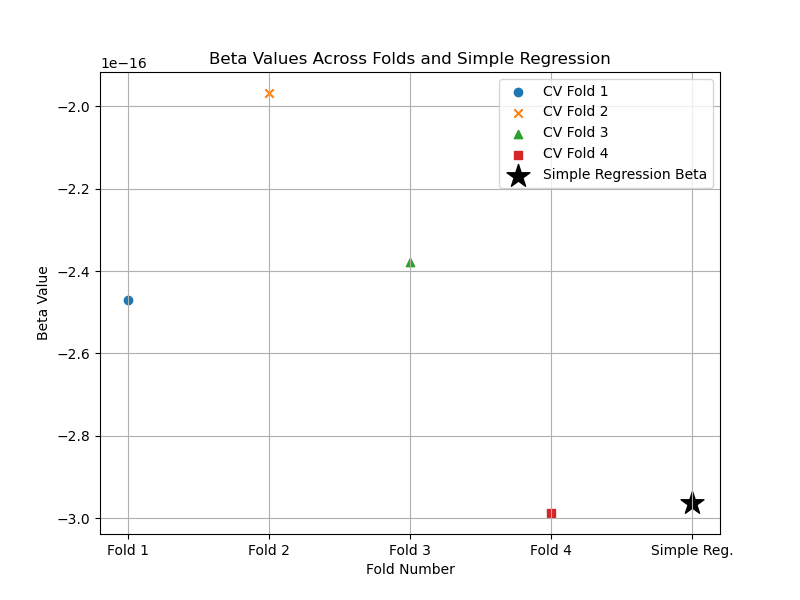

In [56]:
image_path = r'output//imgs//BTC-USD//(2, 1)//cv_betas.png'
image = Image.open(image_path)
display(image)


Naturally, longer training and test periods would allow for less trade flows being 0, and there would less of a negative drift in price across longer periods of time.

### ETH-USD

In [68]:
tau_T_val = (2, 1)
pair = 'ETH-USD'
scaled_r_hat_2_1 = results_dict[pair][*tau_T_val]['test']['ScaledPredictedReturns']
scaled_reg_beta_2_1 = results_dict[pair][*tau_T_val]['train']['ScaledRegBeta']
reg_beta_2_1 = results_dict[pair][*tau_T_val]['train']['RegressionBeta']
scaled_reg_beta_2_1, reg_beta_2_1


(-0.024429624810642998, -6.448000755557964e-17)

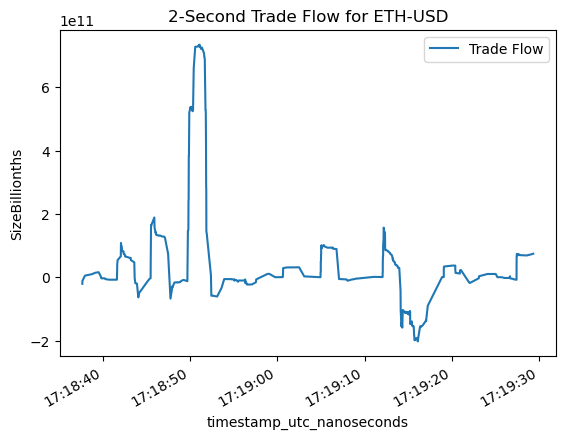

In [63]:
trade_flow = results_dict[pair][*tau_T_val]['test']['TestSet']['TradeFlow']
trade_flow[0:1000].plot(label='Trade Flow')
plt.ylabel('SizeBillionths')
plt.title('2-Second Trade Flow for ETH-USD')
plt.legend()
plt.show()

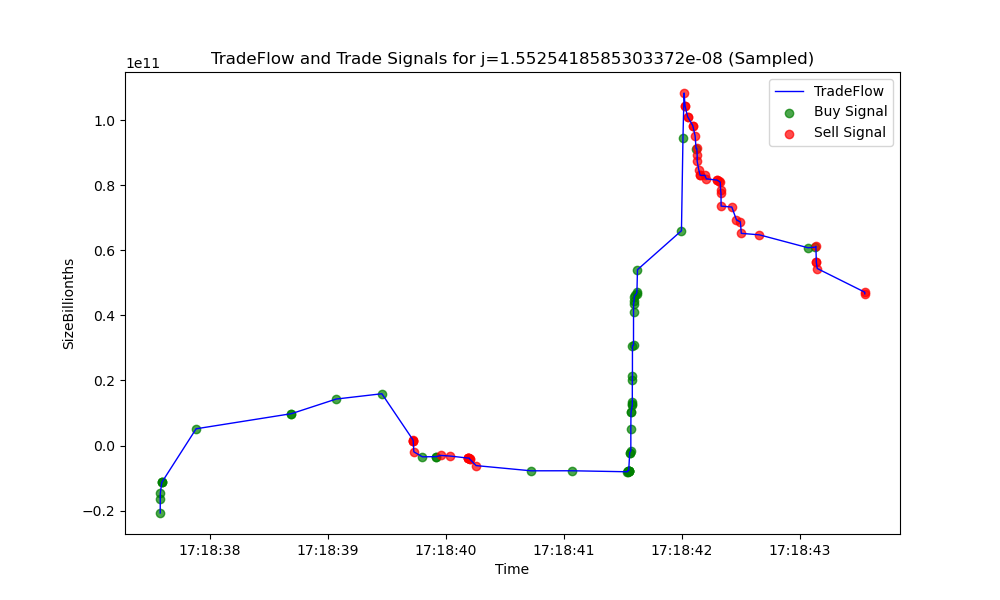

In [59]:
image_path = r'output\\imgs\\ETH-USD\\(2, 1)\\0.0\\TradeFlow_1.5525418585303372e-08_signals.png'
image = Image.open(image_path)
display(image)

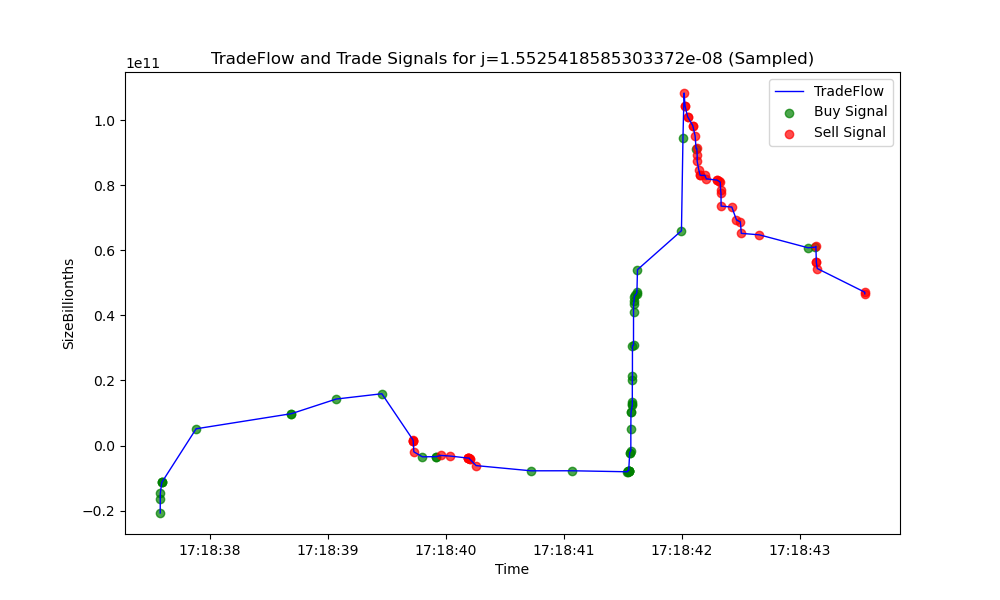

In [60]:
image_path = r'output\\imgs\\ETH-USD\\(2, 1)\\0.0\\TradeFlow_1.5525418585303372e-08_signals.png'
image = Image.open(image_path)
display(image)

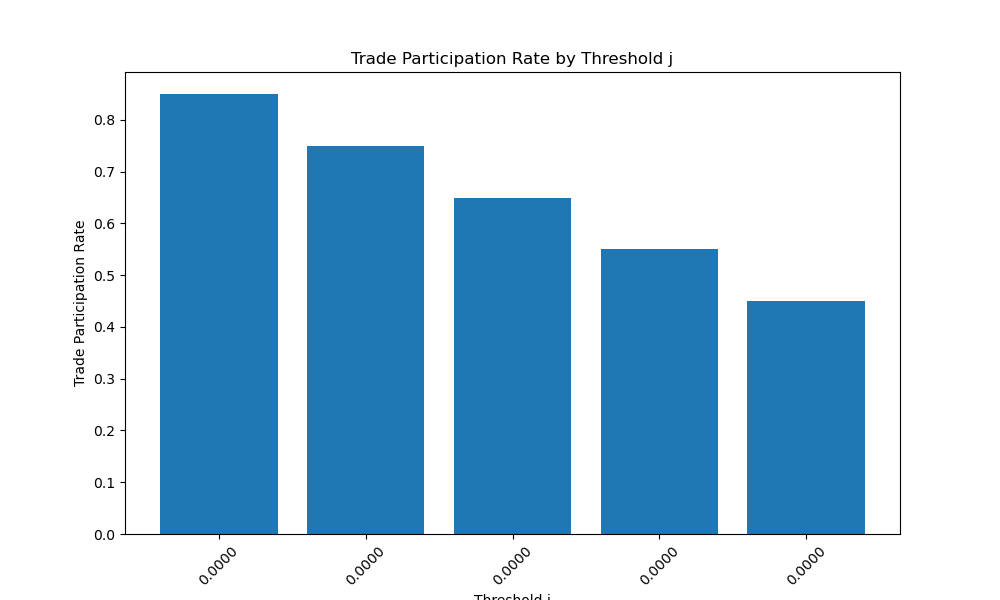

In [61]:
image_path = r'output\\imgs\\ETH-USD\\(2, 1)\\0.0\\participation_rate.png'
image = Image.open(image_path)
display(image)

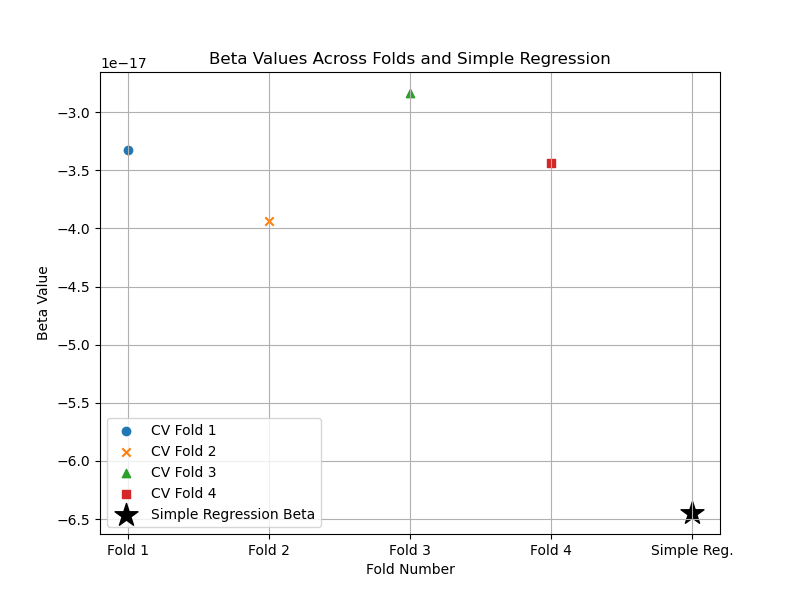

In [64]:
image_path = r'output//imgs//ETH-USD//(2, 1)//cv_betas.png'
image = Image.open(image_path)
display(image)

### ETH-BTC

In [66]:
pair = 'ETH-BTC'
scaled_r_hat_2_1 = results_dict[pair][*tau_T_val]['test']['ScaledPredictedReturns']
scaled_reg_beta_2_1 = results_dict[pair][*tau_T_val]['train']['ScaledRegBeta']
reg_beta_2_1 = results_dict[pair][*tau_T_val]['train']['RegressionBeta']
scaled_reg_beta_2_1, reg_beta_2_1

(-0.023682435831351788, -4.8836507194661576e-15)

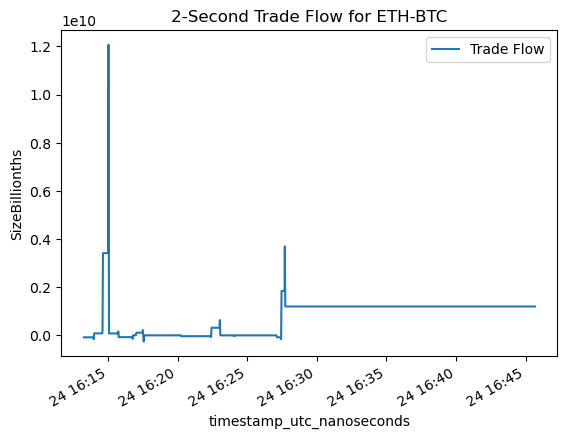

In [67]:
trade_flow = results_dict[pair][*tau_T_val]['test']['TestSet']['TradeFlow']
trade_flow[0:1000].plot(label='Trade Flow')
plt.ylabel('SizeBillionths')
plt.title('2-Second Trade Flow for ETH-BTC')
plt.legend()
plt.show()

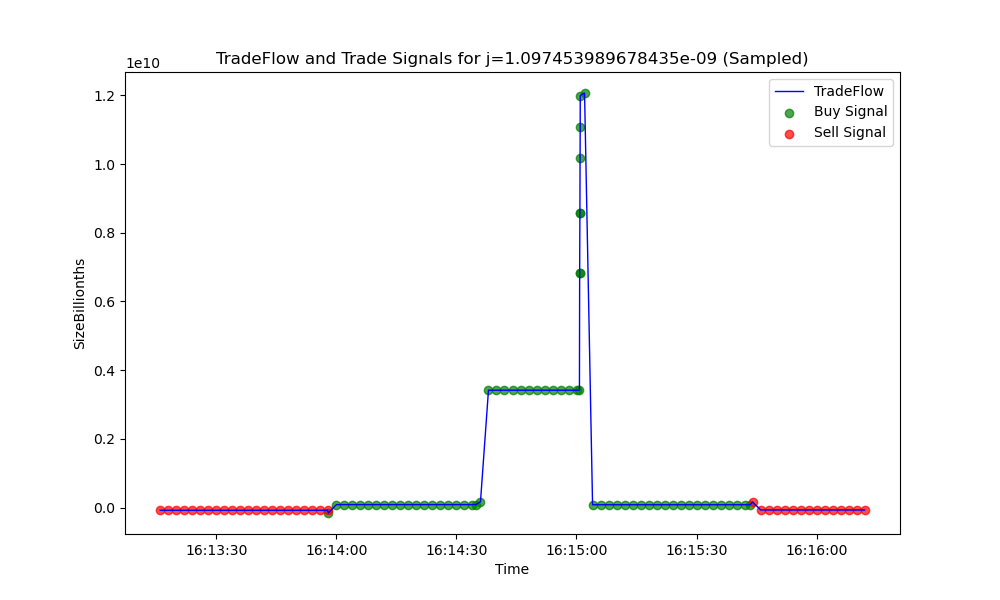

In [72]:
image_path = r'output\\imgs\\ETH-BTC\\(2, 1)\\0.0\\TradeFlow_1.097453989678435e-09_signals.png'
image = Image.open(image_path)
display(image)

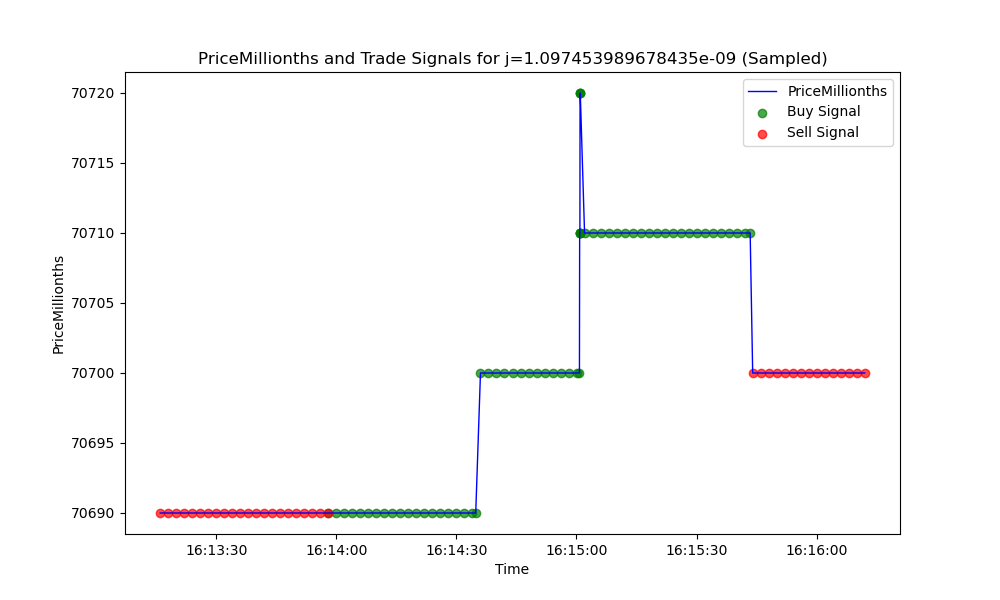

In [71]:
image_path = r'output\\imgs\\ETH-BTC\\(2, 1)\\0.0\\PriceMillionths_1.097453989678435e-09_signals.png'
image = Image.open(image_path)
display(image)

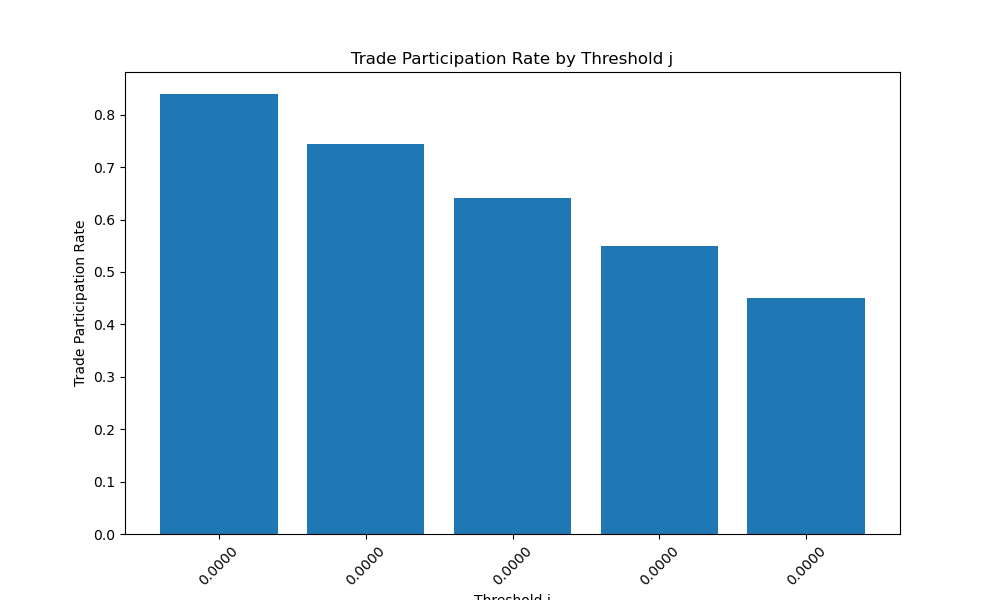

In [70]:
image_path = r'output\\imgs\\ETH-BTC\\(2, 1)\\0.0\\participation_rate.png'
image = Image.open(image_path)
display(image)

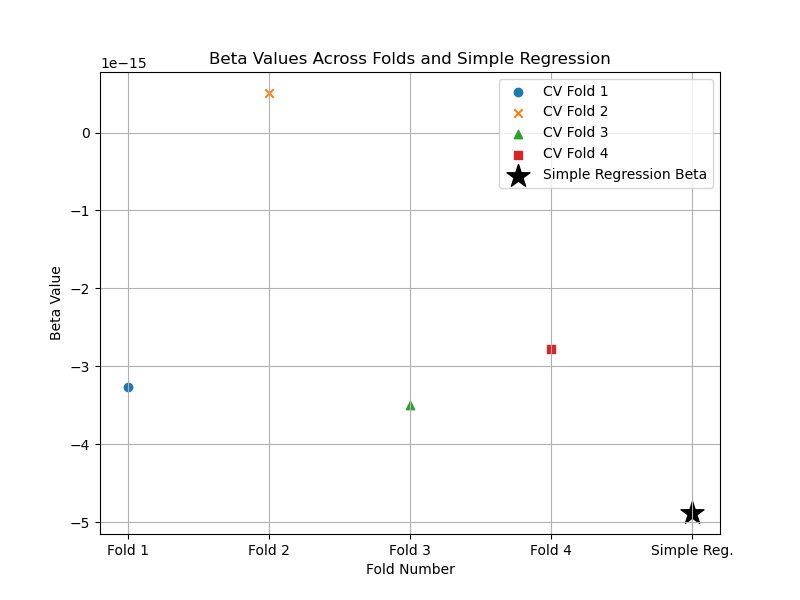

In [73]:
image_path = r'output//imgs//ETH-BTC//(2, 1)//cv_betas.png'
image = Image.open(image_path)
display(image)